# Exploring CICY4 4-folds

In this notebook we explore the distribution of hodge numbers and number of favourable configurations.

In [1]:
import numpy as np
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from datetime import datetime

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# load data
path = '/kaggle/input/calabi-yau-cicy-4-folds'
conf = np.load(os.path.join(path, 'conf.npy'))
hodge = np.load(os.path.join(path, 'hodge.npy'))
direct = np.load(os.path.join(path, 'direct.npy'))
conf.shape, hodge.shape, direct.shape

((921497, 16, 20), (921497, 4), (921497,))

In [4]:
direct[0], conf[0], hodge[0]

(False,
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
  

In [5]:
# PICK ONLY THOSE WITH 'direct = True'
conf = conf[~direct]
hodge = hodge[~direct]
conf.shape, hodge.shape

((905684, 16, 20), (905684, 4))

## How many favourable configs are there?

In [6]:
#sum up the last dimension consecutively
np.sum(conf, axis=-1).shape, np.sum(np.sum(conf, axis=-1) > 0, axis=-1).shape

((905684, 16), (905684,))

In [7]:
number_proj = np.sum(np.sum(conf, axis=-1) > 0, axis=-1)
n_fav = np.sum(number_proj == hodge[:,0])
print('The percentage of fav conf is: {}.'.format(n_fav/len(hodge)))

The percentage of fav conf is: 0.5449384111897748.


In [8]:
h11max = np.max(hodge[:,0])
h11min = np.min(hodge[:,0])
h21max = np.max(hodge[:,1])
h21min = np.min(hodge[:,1])
h31max = np.max(hodge[:,2])
h31min = np.min(hodge[:,2])
h22max = np.max(hodge[:,3])
h22min = np.min(hodge[:,3])
h11max, h11min, h21max, h21min, h31max, h31min, h22max, h22min

(24, 1, 33, 0, 426, 20, 1752, 204)

# Histograms of Hodge numbers

In [9]:
if not os.path.exists('plots'):
    os.makedirs('plots')

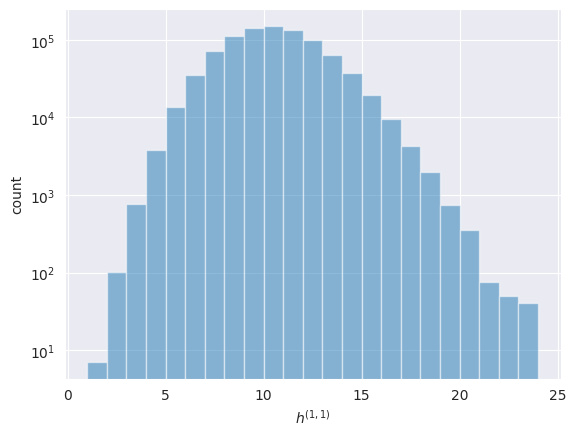

In [10]:
plt.hist(hodge[:,0], bins=range(h11min, h11max+1), alpha=0.5)
plt.xlabel('$h^{(1,1)}$')
plt.ylabel('count')
plt.yscale('log')
plt.savefig(os.path.join('plots', 'z-h11hist.pdf'))

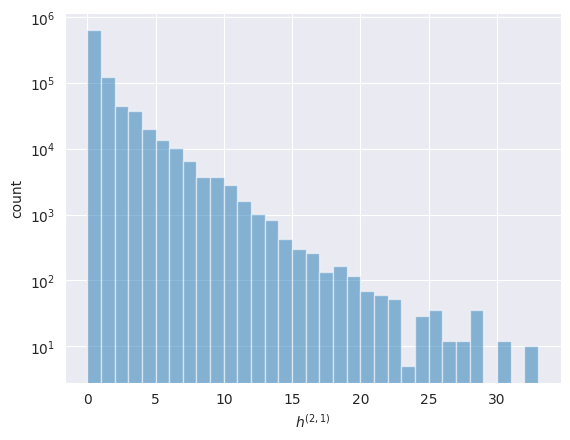

In [11]:
plt.hist(hodge[:,1], bins=range(h21min, h21max+1), alpha=0.5)
plt.xlabel('$h^{(2,1)}$')
plt.ylabel('count')
plt.yscale('log')
plt.savefig(os.path.join('plots', 'z-h21hist.pdf'))

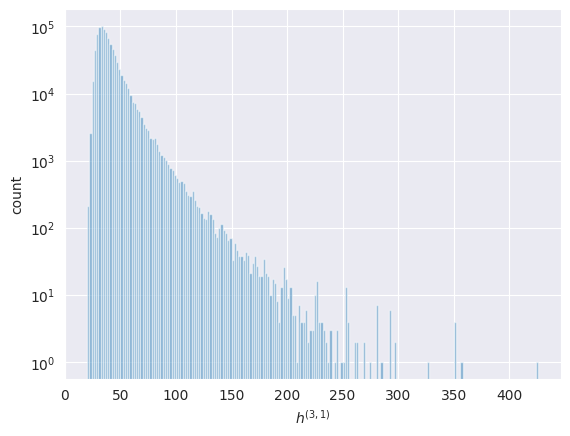

In [12]:
plt.hist(hodge[:,2], bins=range(h31min, h31max+1, 2), alpha=0.5)
plt.xlabel('$h^{(3,1)}$')
plt.ylabel('count')
plt.yscale('log')
plt.savefig(os.path.join('plots', 'z-h31hist.pdf'))

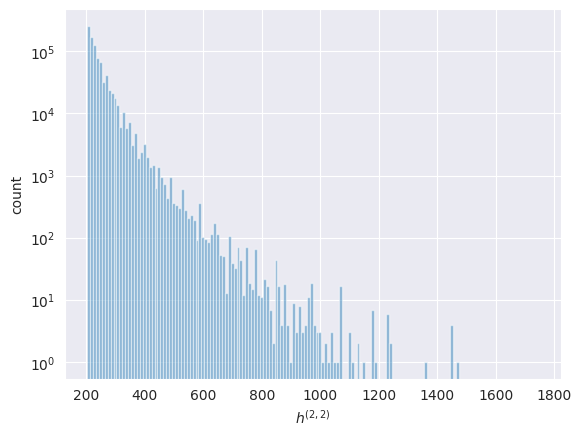

In [13]:
plt.hist(hodge[:,3], bins=range(h22min, h22max+1,10), alpha=0.5)
plt.xlabel('$h^{(2,2)}$')
plt.ylabel('count')
plt.yscale('log')
plt.savefig(os.path.join('plots', 'z-h22hist.pdf'))

# Predict h11

## Custom data generator

In [14]:
X = conf
h11 = hodge[:,0]
y = h11

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train,  X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, shuffle = True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((724547, 16, 20), (724547,), (181137, 16, 20), (181137,))

In [16]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1))

X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1))

In [17]:
def data_generator(X, y, bs = 128):
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(len(y))/bs)
    for i in range(n_batches):
    #this is to account for the last batch
    #which may not be a full size batch
        end = min((i+1)*bs, len(y))

        X_batch = X[i*bs:end]
        y_batch = y[i*bs:end]
        
        #do not use 'return' since this is a data generator
        yield X_batch, y_batch

In [18]:
for inputs, targets in data_generator(X_train, y_train):
    print('INPUTS:' 'shape:', inputs.shape, '\n inputs:', inputs[:1])
    print('TARGETS:' 'shape:', targets.shape, '\n targets:', targets[:1])
    break

INPUTS:shape: torch.Size([128, 16, 20]) 
 inputs: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667,
          0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1667, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000, 0.1667, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.00

In [19]:
train_gen = lambda: data_generator(X_train, y_train)
test_gen = lambda: data_generator(X_test, y_test)

## Training loop

In [20]:

def batch_gd(model, criterion, optimizer, epochs, batch_size=128, cnn = False):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for i in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, target in train_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)

        optimizer.zero_grad()
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, target in test_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        out = model(inputs)
        loss = criterion(out, target)
        test_loss.append(loss.item())
        
    test_loss = np.mean(test_loss)

    train_losses[i] = train_loss
    test_losses[i] = test_loss

    dt = datetime.now()-t0
    print(f'Epoch: {i+1}/{epochs}, train loss: {train_loss: .4f}\
          test_loss: {test_loss: .4f}, duration: {dt}')
  return train_losses, test_losses

In [21]:
def calc_accuracy(model, cnn = False):
    model.eval()
    n_correct = 0.
    n_total = 0.
    batch_size =128
    for inputs, target in train_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        #Perform the prediction
        ypred = model(inputs)
        # update counts
        n_correct += (ypred == target).sum().item()
        n_total += target.shape[0]
    train_acc = n_correct / n_total
    
    #TEST SET
    n_correct = 0.
    n_total = 0
    for inputs, target in test_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        out = model(inputs)
        
        # Forward pass
        ypred_test = model(inputs)
        # update counts
        n_correct += (ypred_test == target).sum().item()
        n_total += target.shape[0]
        
        test_acc = n_correct / n_total

    return train_acc, test_acc

# Predict h11: CNN model

In [22]:
class CNN_cicy4_h11(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,128, 4, 1)
        self.conv2 = nn.Conv2d(128,64, 3, 1)
        self.mxpool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.conv_total = nn.Sequential(
            self.conv1,
            self.mxpool,
            self.conv2,
            self.mxpool,
        )
        self.linear1 = nn.Linear(384,768*2)
        self.linear2 = nn.Linear(768*2,512)
        self.linear3 = nn.Linear(512,128)
        self.linear4 = nn.Linear(128,1)

    def forward(self,x):
        x = F.relu(self.conv_total(x))
        x = self.flat(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        
        return x

In [23]:
model = CNN_cicy4_h11()

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN_cicy4_h11(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (conv_total): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Linear(in_features=384, out_features=1536, bias=True)
  (linear2): Linear(in_features=1536, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=1, bias=True)
)

In [25]:
X = X_train[0].to(device)
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')
print('Reshape the size to take in account the batch number')
X = X.view(1,1,16,20)
print(f'The new size is {X.shape}\n')
X = model.conv_total(X)
print(f'Shape of the image after passing through the whole convolution block: \n {X.shape}\n')

X = model.flat(X)
print(f'Shape of the image after passing through the {model.flat}: \n {X.shape}\n')

X = model.linear1(X)
print(f'Shape of the image after passing through the {model.linear1}: \n {X.shape}\n')

X = model.linear2(X)
print(f'Shape of the image after passing through the {model.linear2}: \n {X.shape}\n')

X = model.linear3(X)
print(f'Shape of the image after passing through the {model.linear3}: \n {X.shape}\n')

X = model.linear4(X)
print(f'Shape of the image after passing through the {model.linear4}: \n {X.shape}\n')

Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 1, 16, 20])

Shape of the image after passing through the whole convolution block: 
 torch.Size([1, 64, 2, 3])

Shape of the image after passing through the Flatten(start_dim=1, end_dim=-1): 
 torch.Size([1, 384])

Shape of the image after passing through the Linear(in_features=384, out_features=1536, bias=True): 
 torch.Size([1, 1536])

Shape of the image after passing through the Linear(in_features=1536, out_features=512, bias=True): 
 torch.Size([1, 512])

Shape of the image after passing through the Linear(in_features=512, out_features=128, bias=True): 
 torch.Size([1, 128])

Shape of the image after passing through the Linear(in_features=128, out_features=1, bias=True): 
 torch.Size([1, 1])



In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [27]:
train_losses, test_losses=batch_gd(model, criterion, optimizer, 80,  cnn=True)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/80, train loss:  1.7637          test_loss:  0.9790, duration: 0:00:18.184525
Epoch: 2/80, train loss:  0.7722          test_loss:  0.6064, duration: 0:00:17.132458
Epoch: 3/80, train loss:  0.5373          test_loss:  0.5913, duration: 0:00:17.246436
Epoch: 4/80, train loss:  0.4334          test_loss:  0.4154, duration: 0:00:17.280380
Epoch: 5/80, train loss:  0.3711          test_loss:  0.3706, duration: 0:00:17.317673
Epoch: 6/80, train loss:  0.3275          test_loss:  0.3527, duration: 0:00:17.396196
Epoch: 7/80, train loss:  0.2949          test_loss:  0.3144, duration: 0:00:17.321449
Epoch: 8/80, train loss:  0.2698          test_loss:  0.2980, duration: 0:00:17.268864
Epoch: 9/80, train loss:  0.2494          test_loss:  0.2804, duration: 0:00:17.205690
Epoch: 10/80, train loss:  0.2323          test_loss:  0.2727, duration: 0:00:17.321037
Epoch: 11/80, train loss:  0.2189          test_loss:  0.2673, duration: 0:00:17.272669
Epoch: 12/80, train loss:  0.2072        

In [28]:
train_acc, test_acc = calc_accuracy(model, cnn= True)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.0020, Test acc: 0.0016
